In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy

import inference

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import kinematics
import patch

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [4]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Filter Each Session

## Short Sessions

In [5]:
LL_Manual, LL_Learned = [], []
for session, count in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    print(session.id)
    title = 'ShortSession'+str(count)
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
    
    mouse_pos = kinematics.FixNan(mouse_pos)
    
    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())

    date_times = pd.to_datetime(mouse_pos.index)
    dt = (date_times[1]-date_times[0]).total_seconds()

    P = np.load('LongSession0Parameters.npz',allow_pickle=True)
    sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
    
    Q = sigma_a**2*Qe

    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    LL_Learned.append(filterRes['logLike'])

    sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = kinematics.LDSParameters_Manual(dt=0.02)    
    Q = sigma_a**2*Qe

    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    LL_Manual.append(filterRes['logLike'])

BAA-1100700
BAA-1101818


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101819


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: invalid value encountered in subtract
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101818


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101818


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: invalid value encountered in subtract
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101823


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: invalid value encountered in subtract
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101821


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101819


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


BAA-1101818


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101819


/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/anaconda3/envs/lds/lib/python3.9/site-packages/numpy/linalg/linalg.py:2086: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


BAA-1101818
BAA-1101819


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


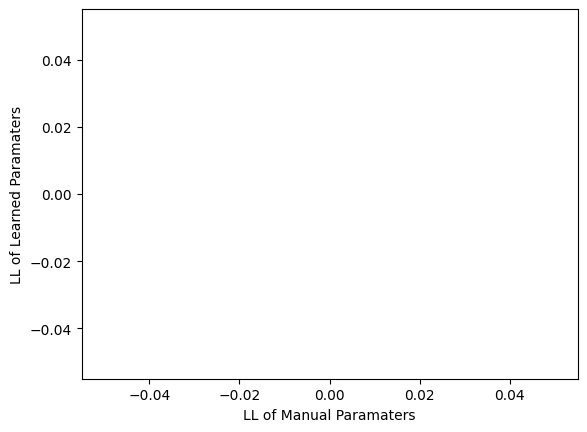

In [6]:
plt.scatter(LL_Manual, LL_Learned)
plt.xlabel("LL of Manual Paramaters")
plt.ylabel("LL of Learned Paramaters")
plt.show()

In [8]:
LL_Learned

[array([[inf]]),
 array([[inf]]),
 array([[nan]]),
 array([[-3114886.00816232]]),
 array([[nan]]),
 array([[nan]]),
 array([[-33341017.13399659]]),
 array([[nan]]),
 array([[nan]]),
 array([[nan]]),
 array([[-1.69507792e+41]]),
 array([[-inf]])]

In [9]:
LL_Manual

[array([[inf]]),
 array([[nan]]),
 array([[-inf]]),
 array([[-inf]]),
 array([[-inf]]),
 array([[-3.6231892e+08]]),
 array([[nan]]),
 array([[-inf]]),
 array([[nan]]),
 array([[inf]]),
 array([[inf]]),
 array([[inf]])]

In [12]:
np.save("LL.npy", LL_Manual)

## Long Sessions

In [ ]:
P = np.load('LongSession0Parameters.npz',allow_pickle=True)
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
dt = 0.019968

for session, count in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    print(session.id)
    title = 'LongSession'+str(count)
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
        
    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())
    sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = kinematics.LDSParameters_Learned(obs[:,:2000], dt, sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, Z)
    np.savez(title + 'Parameters.npz', sigma_a = sigma_a, sigma_x = sigma_x, sigma_y = sigma_y, sqrt_diag_V0_value = sqrt_diag_V0_value, B = B, Qe = Qe, m0 = m0, V0 = V0, Z = Z, R = R)
        
    Q = sigma_a**2*Qe

    filterRes = inference.filterLDS_SS_withMissingValues_np(
            y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    np.savez_compressed(title + 'filterRes.npz', **filterRes)
        
    smoothRes = inference.smoothLDS_SS( 
            B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
            xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)
    np.savez_compressed(title + 'smoothRes.npz', **smoothRes)
    
    patch.AddKinematics(title, mouse_pos)


    mouse_pos = mouse_pos.dropna(subset=['x'])
    fig, axs = plt.subplots(4,1, figsize = (40,24))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_position_x.plot(ax = axs[1])
    mouse_pos.smoothed_position_y.plot(ax = axs[1])
    mouse_pos.smoothed_speed.plot(ax = axs[2])
    mouse_pos.smoothed_acceleration.plot(ax = axs[3])
    plt.savefig('images/Kinematics/' + title+'.png')

In [12]:
count

0